In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
import cv2

In [11]:
import zipfile

In [12]:
# Set dataset path
dataset_path_zip = "/content/archive.zip"

dataset_path = "/content/dataset"  # Choose a directory to extract to

# Extract the zip file
with zipfile.ZipFile(dataset_path_zip, 'r') as zip_ref:
    zip_ref.extractall(dataset_path)

# Initialize variables
data = []
labels = []

In [13]:
for category in ["with_mask", "without_mask"]:
    folder = os.path.join(dataset_path, category)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = image / 255.0  # Normalize
        data.append(image)
        labels.append(category)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [14]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [15]:

print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")

Data shape: (3833, 224, 224, 3)
Labels shape: (3833,)


In [16]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = np.array(labels)

In [17]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                  test_size=0.20, stratify=labels, random_state=42)

In [18]:
aug = ImageDataGenerator(rotation_range=20,
                         zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True,
                         fill_mode="nearest")

In [19]:
# Load MobileNetV2
baseModel = MobileNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))


<ipython-input-19-cce13deb5fae>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False,


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [20]:

# Freeze base model layers
baseModel.trainable = False

In [21]:
# Add custom head
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

In [22]:

# Combine base and head into final model
model = Model(inputs=baseModel.input, outputs=headModel)

# Compile the model
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=INIT_LR),
              metrics=["accuracy"])


In [23]:
H = model.fit(aug.flow(trainX, trainY, batch_size=BS),
              steps_per_epoch=len(trainX) // BS,
              validation_data=(testX, testY),
              validation_steps=len(testX) // BS,
              epochs=EPOCHS)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


95/95 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.7330 - loss: 0.5425 - val_accuracy: 0.9726 - val_loss: 0.1425
Epoch 2/20
 1/95 ━━━━━━━━━━━━━━━━━━━━ 1:14 797ms/step - accuracy: 0.9688 - loss: 0.1148

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


95/95 ━━━━━━━━━━━━━━━━━━━━ 21s 218ms/step - accuracy: 0.9688 - loss: 0.1148 - val_accuracy: 0.9726 - val_loss: 0.1413
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.9512 - loss: 0.1516 - val_accuracy: 0.9791 - val_loss: 0.0889
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 42s 436ms/step - accuracy: 0.9375 - loss: 0.1394 - val_accuracy: 0.9791 - val_loss: 0.0894
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.9685 - loss: 0.1033 - val_accuracy: 0.9844 - val_loss: 0.0708
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 21s 218ms/step - accuracy: 0.9062 - loss: 0.1344 - val_accuracy: 0.9844 - val_loss: 0.0702
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.9658 - loss: 0.0893 - val_accuracy: 0.9817 - val_loss: 0.0626
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 21s 218ms/step - accuracy: 0.9375 - loss: 0.1069 - val_accuracy: 0.9844 - val_loss: 0.0634
Epoch 9/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.9684 - loss: 0.0877 - val_accuracy: 0.9817 - val_

In [25]:
# Evaluate the model
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = (predIdxs > 0.5).astype("int32")

print(classification_report(testY, predIdxs, target_names=lb.classes_))


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 840ms/step
              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



In [26]:
# Save the model
model.save("face_mask_detector_model.h5")


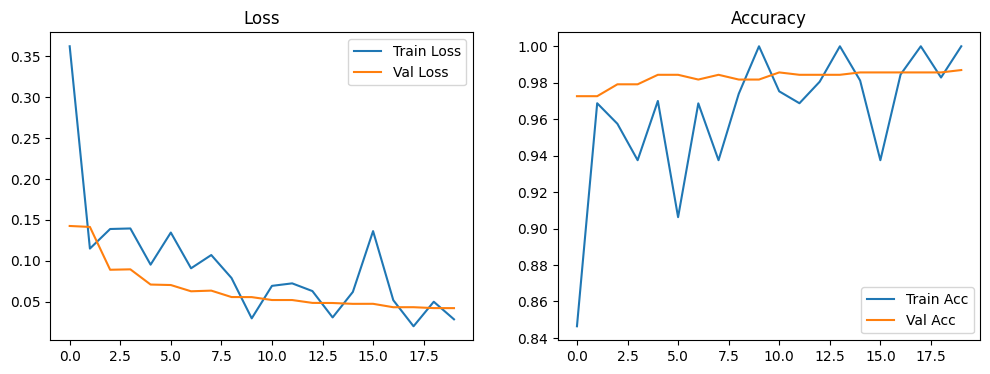

In [27]:
# Plot training results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(H.history["loss"], label="Train Loss")
plt.plot(H.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(H.history["accuracy"], label="Train Acc")
plt.plot(H.history["val_accuracy"], label="Val Acc")
plt.legend()
plt.title("Accuracy")
plt.show()